In [1]:
import string
import csv
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import gensim
from gensim import corpora, models, similarities

# Building Recommender
To build this recommender, I used an approach of a hybrid between Cluster-based collaborative Filtering (CBCF) and Latent Sematic Indexing (LSI). The advantage of CBCF is to help solve the sparsity of the user-product matrix and LSI define a better product regime clusters.


In [4]:
#Import users datatable
users = pd.read_csv('MakeupAlley_users_1.csv')
users.head()

,Unnamed: 0,product_id,user_id,age,skin_type,skin_tone,skin_temp,review,user_rating,userID,skintype_code,skintone_code,age_code
0,0,1,KeithRichards,19-24,sensitive,Fair-Medium,Warm,This is one of my favorite masks. I can't beli...,5,1,0,1,1
1,1,1,violaceopes,19-24,sensitive,Fair,Warm,"I have very oily skin, and Mint Julep Masque i...",4,2,0,0,1
2,2,1,stacy199512,19-24,acne-prone,Fair,Not Sure,Love this stuff! I have oily & combo skin and ...,5,3,1,0,1
3,3,1,PeachSpice,18 & Under,acne-prone,Fair,Not Sure,Skin type: oily/acne prone I have the tube ver...,5,4,1,0,0
4,4,1,eb458310,25-29,acne-prone,Medium,Not Sure,Great stuff! I've been using this product for ...,5,5,1,2,2


In [89]:
#Import product table
products = pd.read_csv('MakeupAlley_products_1.csv')
#Label product types (masks, cleansers, moisturizers)
label = []
for i in range(0,products.shape[0]):
    if products['product_type'].iloc[i] == 'Masks':
        label.append(1)
    elif products['product_type'].iloc[i] == 'Cleansers':
        label.append(2)
    else:
        label.append(3)

In [5]:
#Split data into train set and test set
train_data, test_data = train_test_split(users, test_size=0.2)

In [70]:
#Predicting user rating for the train set from similarity matrices (user-user or item-item)
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

## Principle of LSI
LSA is a widely used technique in natural language processing to identify the similarity between documents, . LSA transforms each document into a vector in a space of features. In our case, the features are words occuring in the document. Then, a matrix containing all vectors is created: columns represent the documents and rows represent unique words. Accordingly, the number of rows can amount to tens of thousands of words. In order to identify the relevant features of this matrix, the "singular value decomposition" (SVD), which is a popular dimension reduction technique, is used to reduce the number of rows -words- while maintaining and highlighting the similarity between columns -synopses-. The dimension of this approximation matrix is set by a hyper-parameter which is the number of topics. In this framework, a topic consists of a set of words with associated weights defining the contribution of each word to the direction of this topic. Based on this low-dimensional approximation matrix, the similarity between two columns -documents- is calculated using the cosine of the angle between these two vectors.
(ref:https://www.kernix.com/blog/recommender-system-based-on-natural-language-processing_p10)


In [7]:
#Preprocessing text
def clean_review(review):
    review = str(review)
    review_nopunc = ''.join([char for char in review.lower() if char not in string.punctuation])
    punctuation = list(string.punctuation)
    letter = list(string.ascii_lowercase)
    stopwordlist = stopwords.words('english') + punctuation + letter
    #review_remove = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", review).split())
    review_nostopwords = [word for word in review_nopunc.lower().split() if word not in stopwordlist]
    #sb_stemmer = SnowballStemmer("english")
    #review_stemmed = [sb_stemmer.stem(word) for word in review_nostopwords]
    return review_nostopwords

In [93]:
#Group review by product so each product is represented by a document of reviews and clean reviews.
train_data['review'] = train_data['review'].apply(lambda x:str(x)) #Convert review data to string
review_byid = train_data.groupby('product_id')['review'].apply(lambda x: "{%s}" % ' '.join(x))
reviews_cleaned = review_byid.apply(clean_review) 

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [398]:
#Build LSI model and calculate pairwise cosine similarity between products
dictionary = corpora.Dictionary(reviews_cleaned)
corpus = [dictionary.doc2bow(text) for text in reviews_cleaned]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5)
model_corpus = lsi[corpus_tfidf]
num=100

#Calculate pairwise cosine similarity between products
index = similarities.MatrixSimilarity(model_corpus, num_features=num)
LSI_similarity = np.array([sim for sim in index])
LSI_dist = 1-LSI_similarity

In [399]:
predict_LSI = predict(train_data_matrix_CBCF,LSI_dist,type='item')

## Testing the traditional item-based collaborative filtering
This problem with this is the data matrix is really sparse, we will see how bad this technique operates in the validation section

In [80]:
#Create two user-item matrices, one for training and another for testing 
#The data in test set are zeroed out in the train set
n_users = users['userID'].nunique()
n_items = users['product_id'].nunique()
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[10]-1, line[2]-1] = line[9]  
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[10]-1, line[2]-1] = line[9]  
#Generate item similarity with cosine metric
item_similarity_CF = pairwise_distances(train_data_matrix.T, metric='cosine')


In [81]:
predict_CF = predict(train_data_matrix,item_similarity_CF,kind='item')

# Clustering-based smoothing collaborative filtering
The idea of this is to use some form of clustering users to fill in the missing rating values in the train data set, to help solve the sparsity problem.
In this case the users provide age and skin type so this will be used to cluster users.
In the first case, I simply used skin type to group users but in the second case, I used Kmean
clustering to cluster users to 50 groups.


### Grouping users by skintype

In [328]:
skintypecluster = train_data.groupby(['skintype_code','product_id'])['user_rating'].mean().reset_index()
skintypecluster_rating = pd.pivot_table(skintypecluster,index='skintype_code',columns='product_id',values='user_rating',fill_value=0)
skintypecluster_rating_matrix = np.array(skintypecluster_rating)

In [333]:
userIDs = []
ave_ratings = []
productIDs = []
product_ids = np.arange(0,465)
cluster = users.groupby('skintype_code')['userID'].unique()
for i in range(0,7):
    cluster_i = cluster[i]
    ave_rating = skintypecluster_rating_matrix[i]
    userIDs = userIDs +465*[cluster_i[j] for j in range(0,len(cluster_i))]
    productIDs = productIDs+list(itertools.chain.from_iterable(itertools.repeat(x, len(cluster_i)) for x in product_ids))
    ave_ratings = ave_ratings+list(itertools.chain.from_iterable(itertools.repeat(x, len(cluster_i)) for x in ave_rating))

In [334]:
skintype_averating = pd.DataFrame()
skintype_averating['userID'] = userIDs
skintype_averating['product_id'] = productIDs
skintype_averating['ave_rating']=ave_ratings
skintype_averating_pivot = pd.pivot_table(skintype_averating,index='userID',columns='product_id',values='ave_rating')
skintype_averating_pivot_matrix = np.array(skintype_averating_pivot)

### Alternatively, try another approach by K-mean clustering of users using all user skin profile information

In [57]:
data = users[['age_code','skintype_code','skintone_code']]
kmeans = KMeans(n_clusters=50)
kmeans.fit(data)
users['KM_label'] = list(kmeans.labels_)

In [148]:
meanrating_bylabel = train_data.groupby(['KM_label','product_id'])['user_rating'].mean().reset_index()
KM_rating = pd.pivot_table(meanrating_bylabel,index='KM_label',columns='product_id',values='user_rating',fill_value=0)
KM_rating_matrix = np.array(KM_rating)

In [239]:
userIDs = []
ave_ratings = []
productIDs = []
product_ids = np.arange(0,465)
cluster = users.groupby('KM_label')['userID'].unique()
for i in range(0,50):
    cluster_i = cluster[i]
    ave_rating = KM_rating_matrix[i]
    userIDs = userIDs +465*[cluster_i[j] for j in range(0,len(cluster_i))]
    productIDs = productIDs+list(itertools.chain.from_iterable(itertools.repeat(x, len(cluster_i)) for x in product_ids))
    ave_ratings = ave_ratings+list(itertools.chain.from_iterable(itertools.repeat(x, len(cluster_i)) for x in ave_rating))

KM_df = pd.DataFrame()
KM_df['userID'] = userIDs
KM_df['product_id'] = productIDs
KM_df['ave_rating']=ave_ratings
KM_df = KM_df.sort_values('userID')
KM_pivot = pd.pivot_table(KM_df,index='userID',columns='product_id',values='ave_rating')
KM_pivot_matrix = np.array(KM_pivot)

In [339]:
#Create a user-product matrix for train set
train_data_matrix_CBCF = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix_CBCF[line[10]-1, line[2]-1] = line[9]  
    

In [340]:
zeros = train_data_matrix_CBCF==0
train_data_matrix_CBCF[zeros] = skintype_averating_pivot_matrix[zeros]

In [341]:
#Rezero test set entries in train data matrix
test_user = np.array(test_data['userID']-1)
test_item = np.array(test_data['product_id']-1)
train_data_matrix_CBCF[test_user,test_item] = 0

In [342]:
item_similarity_CBCF = pairwise_distances(train_data_matrix_CBCF.T, metric='cosine')
predict_CBCF = predict(train_data_matrix_CBCF,item_similarity_CBCF,type='item')

In [406]:
#Calculate hybrid distance matrix
item_similarity_hybrid = 0.8*item_similarity_CBCF + 0.2*LSI_dist
predict_hybrid = predict(train_data_matrix_CBCF,item_similarity_hybrid,type='item')

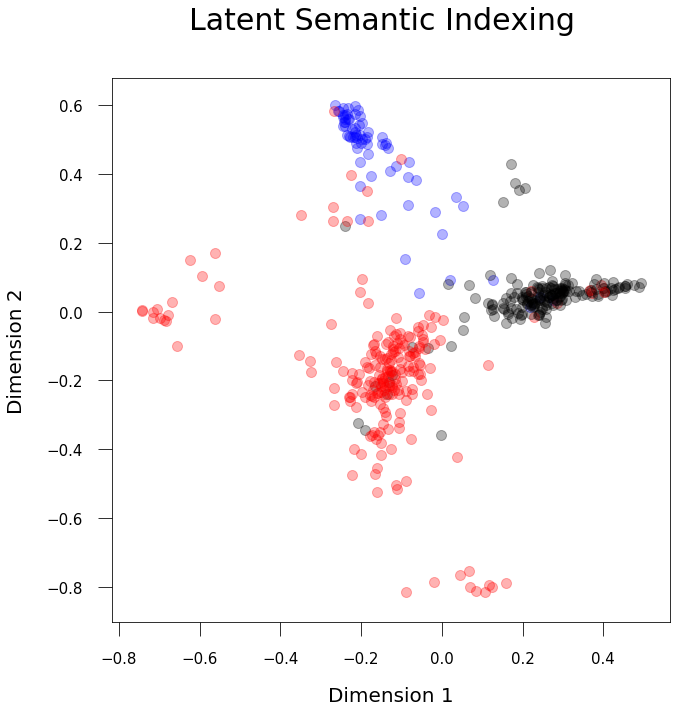

In [430]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(LSI_dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
color = ['blue','red','black']
fig, ax = plt.subplots(figsize=(10,10))
for i in range(0, len(xs)):
    col = color[label[i]-1]
    scatter = ax.scatter(np.array(xs[i]), np.array(ys[i]), c=col, s=100, alpha=0.3) 
plt.xlabel('Dimension 1', fontsize=20, labelpad=20)
plt.ylabel('Dimension 2', fontsize=20, labelpad=20)
plt.suptitle('Latent Semantic Indexing', fontsize=30)
plt.tick_params(labelsize=15, length=14, direction='out', pad=15, top='off', right='off')
plt.savefig('MDS_LSI.png')

# Validation of Recommender
Three type of metrics are used to validate the recommender system: error, classification, and rank-based metrics


# 1/ Error-based metrics

In [413]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
nonzero_test = test_data_matrix > 0

In [416]:
print ('MSE = %0.3f' % mean_squared_error(predict_CF[nonzero_test], test_data_matrix[nonzero_test]))
print ('MAE = %0.3f' % mean_absolute_error(predict_CF[nonzero_test], test_data_matrix[nonzero_test]))

MSE = 15.566
MAE = 3.693


In [417]:
print ('MSE = %0.3f' % mean_squared_error(predict_CBCF[nonzero_test], test_data_matrix[nonzero_test]))
print ('MAE = %0.3f' % mean_absolute_error(predict_CBCF[nonzero_test], test_data_matrix[nonzero_test]))

MSE = 1.938
MAE = 1.207


In [418]:
print ('MSE = %0.3f' % mean_squared_error(predict_LSI[nonzero_test], test_data_matrix[nonzero_test]))
print ('MAE = %0.3f' % mean_absolute_error(predict_LSI[nonzero_test], test_data_matrix[nonzero_test]))

MSE = 1.922
MAE = 1.174


In [419]:
print ('MSE = %0.3f' % mean_squared_error(predict_hybrid[nonzero_test], test_data_matrix[nonzero_test]))
print ('MAE = %0.3f' % mean_absolute_error(predict_hybrid[nonzero_test], test_data_matrix[nonzero_test]))

MSE = 1.920
MAE = 1.176


## 2/ Classification Metrics

In [99]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score

Recall: 1.000
Precision: 0.778
F1 score: 0.875
ROC-AUC: 0.521


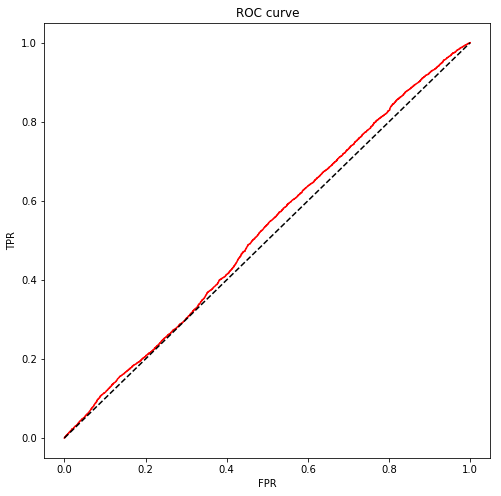

In [420]:
nonzero_test = test_data_matrix > 0
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr


# get non-zero test entries, since we can't evaluate for unsubmitted ratings!
y_true = test_data_matrix[nonzero_test]
y_pred_CBCF = predict_CBCF[nonzero_test]
y_pred_LSI = predict_LSI[nonzero_test]
y_pred_hybdrid = predict_hybrid[nonzero_test]
y_pred_CF = predict_CF[nonzero_test]

# Continous version of predictions, scaled to 0, 1
y_pred_scaled1 = (y_pred1 - 1.) /4
#y_pred_scaled2 = (y_pred2 - 1.) / 4.
#y_pred_scaled3 = (y_pred3 - 1.) / 4.

# binarize true values and predictions
y_pred_binarized1 = binarize(y_pred1.copy(), 3)
#y_pred_binarized2 = binarize(y_pred2.copy(), 3)
#y_pred_binarized3 = binarize(y_pred3.copy(), 3)

y_true_binarized = binarize(y_true.copy(), 3)

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print ('Recall: %0.3f' % recall_score(y_true_binarized, y_pred_binarized1))
print ('Precision: %0.3f' % precision_score(y_true_binarized, y_pred_binarized1))
print ('F1 score: %0.3f' % f1_score(y_true_binarized, y_pred_binarized1))

# roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true_binarized, y_pred_scaled1)
print ('ROC-AUC: %0.3f' % auc_score)

# plot ROC curve
fpr1, tpr1, thresholds = roc_curve(y_true_binarized, y_pred_scaled1)
#fpr2, tpr2, thresholds2 = roc_curve(y_true_binarized, y_pred_scaled2)
#fpr3, tpr3, thresholds3 = roc_curve(y_true_binarized, y_pred_scaled3)

plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1,'r')#,fpr2,tpr2,'b',fpr3,tpr3,'purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# 3/ Rank-based Metrics

In [346]:
def recall_at_k(true, pred, user_ids, k, tol=3.):
    unique_users = np.unique(user_ids)
    pred_binarized = binarize(pred.copy(), tol)
    recalls = np.zeros(unique_users.size)
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        ranked_ind = np.argsort(-user_pred)[:k]
        recalls[i] = recall_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    return np.mean(recalls[recalls > 0])
 
user_ids = np.tile(np.array([np.arange(test_data_matrix.shape[0])]).T, (1, test_data_matrix.shape[1]))[nonzero_test]

print ('recall @4 : %0.3f' % recall_at_k(y_true_binarized, y_pred1, user_ids, 4))
print ('recall @8 : %0.3f' % recall_at_k(y_true_binarized, y_pred1, user_ids, 8))
print ('recall @16 : %0.3f' % recall_at_k(y_true_binarized, y_pred1, user_ids, 16))
print ('recall @32 : %0.3f' % recall_at_k(y_true_binarized, y_pred1, user_ids, 32))

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


recall @4 : 1.000
recall @8 : 1.000
recall @16 : 1.000
recall @32 : 1.000


We also can straightforwardly define the **precision@k** in a similar manner.  However, because recommendation data is of an implicit nature many people do not like precision@k itself as a metric - just because an item is not in the test set does not mean the user will not like it in the future.  This fact tends to make precision@k a bit noisy as a standalone metric.

Instead, another metric that is often used is the **Mean Average Precision @k (MAP@k)**.  This is simply the mean across all users of the **Average Precision@k**.

$$ {\rm Average Precision@}k = \sum_{n=1}^{k} \frac{{\rm Precision@n}}{{\rm min}(n, |\mathbf{y}_u^{\rm test}|)}$$

where $\mathbf{y}_u^{\rm test}$ is the test data for the user.  The benefit of the MAP metric is that it accounts for both precision and recall and penalizes bad items which are ranked early.  The downside it that it is less interpretible than recall@k and precision@k.

In [422]:
def precision_at_k(true, pred, user_ids, k, tol=2.):
    unique_users = np.unique(user_ids)
    pred_binarized = binarize(pred.copy(), tol)
    precisions = np.zeros(unique_users.size)
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        ranked_ind = np.argsort(-user_pred)[:k]
        precisions[i] = precision_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    return precisions
 
def MAP_at_k(true, pred, user_ids, k, tol=2.):
    unique_users = np.unique(user_ids)
    precisions_at_ks = np.zeros((k, unique_users.size))
    for i in range(k):
        precisions_at_ks[i] = precision_at_k(true, pred, user_ids, i+1, tol)
    return np.mean(precisions_at_ks[precisions_at_ks > 0])

In [421]:
print ('MAP @4 : %0.3f' % MAP_at_k(y_true_binarized, y_pred_CBCF, user_ids, 4))
print ('MAP @8 : %0.3f' % MAP_at_k(y_true_binarized, y_pred_CBCF, user_ids, 8))
print ('MAP @16 : %0.3f' % MAP_at_k(y_true_binarized, y_pred_CBCF, user_ids, 16))
print ('MAP @32 : %0.3f' % MAP_at_k(y_true_binarized, y_pred_CBCF, user_ids, 32))

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MAP @4 : nan
MAP @8 : nan
MAP @16 : nan
MAP @32 : nan


In [301]:
def DCG_at_k(true, pred, user_ids, k):
    unique_users = np.unique(user_ids)
    dcgs = np.zeros(unique_users.size)
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        ranked_ind = np.argsort(-user_pred)[:k]
        user_relevances = user_true[ranked_ind]
        gains = 2. ** (user_relevances)
        discounts = np.log2(np.arange(user_relevances.size) + 2)
        dcgs[i] = np.sum(gains / discounts)
    return dcgs

def NDCG_at_k(true, pred, user_ids, k):
    actual_dcgs = DCG_at_k(true, pred, user_ids, k)
    best_dcgs = DCG_at_k(true, true, user_ids, k)
    return np.mean(actual_dcgs / best_dcgs)


print ('NDCG @4 : %0.3f' % NDCG_at_k(y_true, y_pred_CF, user_ids, 4))
print ('NDCG @8 : %0.3f' % NDCG_at_k(y_true, y_pred_CF, user_ids, 8))
print ('NDCG @16 : %0.3f' % NDCG_at_k(y_true, y_pred_CF, user_ids, 16))
print ('NDCG @32 : %0.3f' % NDCG_at_k(y_true, y_pred_CF, user_ids, 32))

NDCG @4 : 0.978
NDCG @8 : 0.979
NDCG @16 : 0.980
NDCG @32 : 0.980
